In [1]:
# 4th Order Hermite Integrator for 3rd Year Physics Project
# Simulates the orbital dynamics of stars, planets etc

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from tqdm import tqdm
from csv import writer

# Importing my own files
from binaryFinder import *
from initialConditionsGenerator import *

# Defining constants
G = np.float64(6.67430e-11) # Newton's Gravitational constant
s = np.float64(6.0e6)       # Softening, gravity "blurring"
e = np.float64(0.007)       # Eta, timestep accuracy parameter
ac = np.float64(1.3)        # Arseth stability criterion
sixth = np.float64(1.0/6.0) # One over Six, for speed

# Function that determines accelerations
@jit(nopython=True)
def accelerations(x, y, z, vx, vy, vz, m, n, nlist):
    # Resetting and allocating memory
    ax = np.zeros(n, dtype=np.float64)
    ay = np.zeros(n, dtype=np.float64)
    az = np.zeros(n, dtype=np.float64)
    adx = np.zeros(n, dtype=np.float64)
    ady = np.zeros(n, dtype=np.float64)
    adz = np.zeros(n, dtype=np.float64)
    gpe = np.zeros(n, dtype=np.float64)

    # First loop through every body
    for i in range(n):
        # Setting GPE for this body to zero
        gpei = np.float64(0)

        # Looping through all other bodies
        for j in nlist[i:i+n]:
            # Resetting gpe
            gpeij = np.float64(0)

            # Allocating variable memory
            dx = np.float64(0)
            dy = np.float64(0)
            dz = np.float64(0)
            dvx = np.float64(0)
            dvy = np.float64(0)
            dvz = np.float64(0)
            r = np.float64(0)
            vdr = np.float64(0)
            dterm3 = np.float64(0)
            dterm5 = np.float64(0)

            # Calculating position and velocity vectors
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]

            dvx = vx[j] - vx[i]
            dvy = vy[j] - vy[i]
            dvz = vz[j] - vz[i]

            # Finding rij and rij dot vij (squared)
            r = np.sqrt(dx*dx + dy*dy + dz*dz + s*s)
            vdr = dx*dvx + dy*dvy + dz*dvz

            # Calculating divison terms
            dterm3 = 1.0/(r*r*r)
            dterm5 = 1.0/(r*r*r*r*r)

            # Calculating the accelerations
            ax[i] = ax[i] + (G * m[j]) * (dx*dterm3)
            ay[i] = ay[i] + (G * m[j]) * (dy*dterm3)
            az[i] = az[i] + (G * m[j]) * (dz*dterm3)

            adx[i] = adx[i] + (G * m[j]) * ((dvx*dterm3) + 3.0*(vdr*dx*dterm5))
            ady[i] = ady[i] + (G * m[j]) * ((dvy*dterm3) + 3.0*(vdr*dy*dterm5))
            adz[i] = adz[i] + (G * m[j]) * ((dvz*dterm3) + 3.0*(vdr*dz*dterm5))

            # Calculating gravitational potential
            gpeij = -1.0 * G * m[i] * m[j] / r
            gpei = gpei + gpeij

        # Setting the gpe of this body after the loop
        gpe[i] = gpei

    # Returning acceleration etc
    return ax, ay, az, adx, ady, adz, gpe

# Function to calculate the timestep
@jit(nopython=True)
def nextTimeStep(ax, ay, az, adx, ady, adz, n, dt):
    # List for timesteps & setting old and new dt values
    dtList = []
    newdt = 0.0
    dt = np.float64(dt)

    # Looping through all bodies to determine their timestep
    for b in range(n):
        # Calculating values of a, ad, add, addd
        a = np.sqrt(ax[b]*ax[b] + ay[b]*ay[b] + az[b]*az[b])
        ad = np.sqrt(adx[b]*adx[b] + ady[b]*ady[b] + adz[b]*adz[b])

        # Calculating timestep
        dtList.append(e*a/ad)

    # Choosing the minimum timestep
    newdt = min(dtList)

    # Preventing timestep jumps from being too large
    if newdt > 1.3*dt:
        newdt = 1.3*dt

    # Returning the new timestep
    return min(dtList)

def output(time, maxTime, xpositions, ypositions, zpositions, xvelocities, yvelocities, zvelocities, masses, numberOfObjects):
    # Defining the name of the file
    fname = "{:.2f}.txt".format(time/maxTime)

    # Opening the file
    with open(fname, "w") as file:
        
        # Writing the headers
        file.write("Time MaxTime Xpos Ypos Zpos Xvel Yvel Zvel Mass \n")

        # Looping through each object 
        for i in range(numberOfObjects):
            file.write(str(time) + " " + str(maxTime) + " ")
            file.write(str(xpositions[i]) + " " + str(ypositions[i]) + " " + str(zpositions[i]) + " ")
            file.write(str(xvelocities[i]) + " " + str(yvelocities[i]) + " " + str(zvelocities[i]) + " ")
            file.write(str(masses[i]) + "\n") 

# Function that initialises the integrator 
def init(dataFile):
    # Importing the ICs from the file
    t, tc, x, y, z, vx, vy, vz, m = np.loadtxt(dataFile, delimiter=" ", skiprows=1, unpack=True, dtype=np.float64)

    #t = np.array([0,0], dtype=np.float64)
    #tc = np.array([3e9, 3e9], dtype=np.float64)
    #x = np.array([0.000000000000000000e+00, 0.000000000000000000e+00], dtype=np.float64)
    #y = np.array([5.661717880000000000e+13, -9.882927930000000000e+13], dtype=np.float64)
    #z = np.array([-1.401299260000000000e+14, 4.933501030000000000e+13], dtype=np.float64)
    #vx = np.array([0.000000000000000000e+00, 0.000000000000000000e+00], dtype=np.float64)
    #vy = np.array([3.404278423499999917e+02, -1.745519354399999941e+02], dtype=np.float64)
    #vz = np.array([-1.175720704000000083e+01, 6.028423619999999872e+00], dtype=np.float64)
    #m = np.array([3.448904680000000157e+29, 6.726383039999999439e+29], dtype=np.float64)

    # Determining the number of bodies
    n = len(x)

    # Setting up the arrays for acceleration
    axp = np.zeros(n, dtype=np.float64)
    ayp = np.zeros(n, dtype=np.float64)
    azp = np.zeros(n, dtype=np.float64)
    adxp = np.zeros(n, dtype=np.float64)
    adyp = np.zeros(n, dtype=np.float64)
    adzp = np.zeros(n, dtype=np.float64)
    xadd = np.zeros(n, dtype=np.float64)
    yadd = np.zeros(n, dtype=np.float64)
    zadd = np.zeros(n, dtype=np.float64)
    xaddd = np.zeros(n, dtype=np.float64)
    yaddd = np.zeros(n, dtype=np.float64)
    zaddd = np.zeros(n, dtype=np.float64)
    axc = np.zeros(n, dtype=np.float64)
    ayc = np.zeros(n, dtype=np.float64)
    azc = np.zeros(n, dtype=np.float64)
    adxc = np.zeros(n, dtype=np.float64)
    adyc =np.zeros(n, dtype=np.float64)
    adzc = np.zeros(n, dtype=np.float64)

    # Setting up arrays for position and velocity
    xp = np.zeros(n, dtype=np.float64)
    yp = np.zeros(n, dtype=np.float64)
    zp = np.zeros(n, dtype=np.float64)
    vxp =np.zeros(n, dtype=np.float64)
    vyp = np.zeros(n, dtype=np.float64)
    vzp = np.zeros(n, dtype=np.float64)
    xc = np.zeros(n, dtype=np.float64)
    yc = np.zeros(n, dtype=np.float64)
    zc = np.zeros(n, dtype=np.float64)
    vxc =np.zeros(n, dtype=np.float64)
    vyc =np.zeros(n, dtype=np.float64)
    vzc = np.zeros(n, dtype=np.float64)

    # Setting up arrays for plotting # TODO: Delete
    xarr = yarr = zarr = dCoM = np.zeros((n, 1), dtype=np.float64)
    tarr = dtarr = np.zeros(1, dtype=np.float64)
    Ke = Ge = Px = Py = Pz = np.zeros((n, 1), dtype=np.float64)

    # Only choosing the 1st value from the time array
    t = t[0]
    tc = tc[0]

    # Returning all the arrays
    return t, tc,  x, y, z, vx, vy, vz, m, n, axp, ayp, azp, adxp, adyp, adzp, xadd, yadd, zadd, xaddd, yaddd, zaddd, axc, ayc, azc, adxc, adyc, adzc, xp, yp, zp, vxp, vyp, vzp, xc, yc, zc, vxc, vyc, vzc, xarr, yarr, zarr, tarr, dtarr, Ke, Ge, Px, Py, Pz, dCoM

# Function that actually runs the integrator
def hermiteIntegrator(dt, dynamicTimestep, outputNumber, fileNumber, dataFile, useCrossingTime, tmax):
    # Initialising
    t, tc, x, y, z, vx, vy, vz, m, n, axp, ayp, azp, adxp, adyp, adzp, xadd, yadd, zadd, xaddd, yaddd, zaddd, axc, ayc, azc, adxc, adyc, adzc, xp, yp, zp, vxp, vyp, vzp, xc, yc, zc, vxc, vyc, vzc, xarr, yarr, zarr, tarr, dtarr, Ke, Ge, Px, Py, Pz, dCoM = init(dataFile)

    # Using the crossing time of the cluster if desired
    if useCrossingTime:
        tmax = tc

    # Setting up counters and progress bar etc
    outputInterval = np.float64(tmax / outputNumber)
    fileInterval = np.float64(tmax / fileNumber)
    outputCounter = 0.0
    fileCounter = 0.0
    progBar = tqdm(total=tmax)
    progBar.update(t)
    
    # List for looping
    nlist = np.arange(0, n, 1, dtype=np.int64)
    nlist = np.append(nlist, nlist)

    # Setting number of times to predict, evaluate and correct
    pecOrder = 2

    # Setting the first timestep using the a over a dot equation if dynamic timestep used
    if dynamicTimestep:
        ax, ay, az, adx, ady, adz, _ = accelerations(x, y, z, vx, vy, vz, m, n, nlist)
        dt = min(np.sqrt(e * (ax*ax + ay*ay + az*az) / (adx*adx + ady*ady + adz*adz)))

    try:
        # The main while loop of the function
        while t < tmax:
            # Calculating dt powers 
            dt = np.float64(dt)
            dt2 = dt*dt
            dt3 = dt*dt*dt
            dt4 = dt*dt*dt*dt
            dt5 = dt*dt*dt*dt*dt

            # Prediction step
            axp, ayp, azp, adxp, adyp, adzp, _ = accelerations(x, y, z, vx, vy, vz, m, n, nlist)

            xp = x + vx*dt + axp*dt2*0.5 + adxp*dt3*sixth
            yp = y + vy*dt + ayp*dt2*0.5 + adyp*dt3*sixth
            zp = z + vz*dt + azp*dt2*0.5 + adzp*dt3*sixth

            vxp = vx + dt*axp + 0.5*adxp*dt2
            vyp = vy + dt*ayp + 0.5*adyp*dt2
            vzp = vz + dt*azp + 0.5*adzp*dt2

            # Start the loop through for correcting
            for it in range(pecOrder):
                # Using predicited p and v for first evaluation, corrected for all else
                if it == 0:
                    axc, ayc, azc, adxc, adyc, adzc, gp = accelerations(xp, yp, zp, vxp, vyp, vzp, m, n, nlist)
                else:
                    axc, ayc, azc, adxc, adyc, adzc, gp = accelerations(xc, yc, zc, vxc, vyc, vzc, m, n, nlist)

                # Determining higher order corrections 
                xadd = np.float64(-6.0)*(axp - axc)/dt2 - (np.float64(4.0)*adxp + np.float64(2.0)*adxc)/dt
                yadd = np.float64(-6.0)*(ayp - ayc)/dt2 - (np.float64(4.0)*adyp + np.float64(2.0)*adyc)/dt
                zadd = np.float64(-6.0)*(azp - azc)/dt2 - (np.float64(4.0)*adzp + np.float64(2.0)*adzc)/dt

                xaddd = np.float64(12.0)*(axp - axc)/dt3 + np.float64(6.0)*(adxp + adxc)/dt2
                yaddd = np.float64(12.0)*(ayp - ayc)/dt3 + np.float64(6.0)*(adyp + adyc)/dt2
                zaddd = np.float64(12.0)*(azp - azc)/dt3 + np.float64(6.0)*(adzp + adzc)/dt2

                # Adding the corrections 
                xc = xp + dt4*xadd/np.float64(24.0) + dt5*xaddd/np.float64(120.0)
                yc = yp + dt4*yadd/np.float64(24.0) + dt5*yaddd/np.float64(120.0)
                zc = zp + dt4*zadd/np.float64(24.0) + dt5*zaddd/np.float64(120.0)

                vxc = vxp + dt3*xadd/np.float64(6.0) + dt4*xaddd/np.float64(24.0)
                vyc = vyp + dt3*yadd/np.float64(6.0) + dt4*yaddd/np.float64(24.0)
                vzc = vzp + dt3*zadd/np.float64(6.0) + dt4*zaddd/np.float64(24.0)

            # Updating the positions and velocities with the final solution
            x = xc; y = yc; z = zc; vx = vxc; vy = vyc; vz = vzc

            # Updating the timestep
            if dynamicTimestep:
                dt = nextTimeStep(axc, ayc, azc, adxc, adyc, adzc, n, dt)
            
            # Ticking the clock
            t = t + dt
            outputCounter = outputCounter + dt
            fileCounter = fileCounter + dt

            # Outputing based on the given time interval
            if outputCounter >= outputInterval:
                # Update progress bar
                progBar.update(outputCounter)

                # Appendng to arrays
                xarr = np.append(xarr, np.array_split(x, n), axis=1)
                yarr = np.append(yarr, np.array_split(y, n), axis=1)
                zarr = np.append(zarr, np.array_split(z, n), axis=1)
                tarr = np.append(tarr, t)
                dtarr = np.append(dtarr, dt)

                # Calculating the conserved quantities
                ke = np.float64(0.5) * m * np.sqrt(vx*vx + vy*vy + vz*vz)**2
                pmx = m * vx
                pmy = m * vy
                pmz = m * vz

                # Appending calcualted values to arrays
                Px = np.append(Px, np.array_split(pmx, n), axis=1) # Momentum
                Py = np.append(Py, np.array_split(pmy, n), axis=1) # Momentum
                Pz = np.append(Pz, np.array_split(pmz, n), axis=1) # Momentum
                Ke = np.append(Ke, np.array_split(ke, n), axis=1) # Kinetic Energy
                Ge = np.append(Ge, np.array_split(gp, n), axis=1) # Gravitational Potential Energy

                # Calculating the centre of mass of the cluster
                comx = np.sum(x * m)/np.sum(m)
                comy = np.sum(y * m)/np.sum(m)
                comz = np.sum(z * m)/np.sum(m)

                # Subtracting this from the original position
                dcomx = x - comx
                dcomy = y - comy
                dcomz = z - comz

                # Calculating the magnitude of the distance and adding to the arrays
                dcom = np.sqrt(dcomx**2 + dcomy**2 + dcomz**2)
                dCoM = np.append(dCoM, np.array_split(dcom, n), axis=1)

                # Resetting output counter
                outputCounter = 0

                if fileCounter >= fileInterval:

                    # Outputting a file
                    #output(t, tmax, x, y, z, vx, vy, vz, m, n)

                    # Resetting file counter
                    fileCounter = 0

                    # Running the binary finder
                    r, c, ti, tt, _, _, _, _, _, _, _, _, _, _, _, _, _, _ = binaryCheck(x, y, z, vx, vy, vz, m, n)

                    print(r, c, ti, tt)

    except KeyboardInterrupt:
        pass

    # Closing the progress bar when complete
    progBar.close()
    
    # Doing a final output and binary find
    #output(t, tmax, x, y, z, vx, vy, vz, m, n)
    rf, cf, tif, ttf, bE, bA, bM, bP, be, bO, bR, tE, tA, tM, tP, te, tO, tR  = binaryCheck(x, y, z, vx, vy, vz, m, n)

    # Lists for confirmed binaries
    ro = []; co = []; tio = []; tto = []

    # List for confirmed binary data
    bEo = []; bAo = []; bMo = []; bPo = []; beo = []; bOo = []; bRo = []; tEo = []; tAo = []; tMo = []; tPo = []; teo = []; tOo = []; tRo = [];

    # Checking that the binaries found previously still exist
    bWOT = 0

    for i in range(len(rf)):
        # Keeping track of if we have a triple or not
        if tif[i] == "N/A":
            bWOT = bWOT + 1

        # Looping through all the binaries in previous binary check
        for j in range(len(r)):
            if rf[i] == r[j] and cf[i] == c[j]:
                ro.append(rf[i])
                co.append(cf[i])
                tio.append(tif[i])
                tto.append(ttf[i])

                bEo.append(bE[i])
                bAo.append(bA[i])
                bMo.append(bM[i])
                bPo.append(bP[i])
                beo.append(be[i])
                bOo.append(bO[i])
                bRo.append(bR[i])

                if ttf[i] == "Binary-Star":
                    tEo.append(tE[i-bWOT])
                    tAo.append(tA[i-bWOT])
                    tMo.append(tM[i-bWOT])
                    tPo.append(tP[i-bWOT])
                    teo.append(te[i-bWOT])
                    tOo.append(tO[i-bWOT])
                    tRo.append(tR[i-bWOT])

    # Opening the binary data csv file to write to it
    with open("binaryData.csv", "a") as file:
        # Getting a writer object
        writ = writer(file)
         
        # Writing the data
        for b in range(len(ro)):
            data = [bEo[b], bAo[b], bMo[b], bPo[b], beo[b], bOo[b], bRo[b]]
            writ.writerow(data)

        # Closing the file
        file.close()

    # Opening the triple data csv file to write to it
    with open("tripleData.csv", "a") as file:
        # Getting a writer object
        writ = writer(file)

        # Writing the data 
        for b in range(len(tEo)):
            data = [tEo[b], tAo[b], tMo[b], tPo[b], teo[b], tOo[b], tRo[b]]
            writ.writerow(data)

    # Writing the binary fraction data to another file
    with open("binaryNumbers.csv", "a") as file:
        # Getting writer object
        writ = writer(file)

        # Writing the data
        writ.writerow([n, 2*len(ro), 3*len(tEo)])

        # Closing the file
        file.close()

    print(ro, co, tio, tto)
    
    
    # Returning the arrays
    return Ge, Ke, Px, Py, Pz, xarr, yarr, zarr, dtarr, tarr, dCoM


''' Main Program Call '''


# Asking for simulation parameters
textFile = input("Name of the data file: ")
outputNumber = input("Number of Outputs: ")
fileNumber = input("Number of Output Files: ")
dynamicTimeStep = input("Dynamic Time Step? (Y or N): ")

if dynamicTimeStep == "Y":
    dyn = True
    initialdt = 0
else:
    dyn = False
    initialdt = input("Time-step: ")

useCrossing = input("Use crossing time as max time? (Y or N): ")

if useCrossing == "Y":
    useCrossingTime = True
    maximumTime = 0
else:
    useCrossingTime = False
    print("Maximum Time Selection \n")
    timeUnit = input("Unit of Time (GYear, MYear, kYear, Year, Month, Week, Day): ")
    timeNumber = input("Number of Time Units: ")

    if timeUnit == "GYear":
        timeUnit = 1e9 * 365*24*60*60
    elif timeUnit == "MYear":
        timeUnit = 1e6 * 365*24*60*60
    elif timeUnit == "kYear":
        timeUnit = 1e3 * 365*24*60*60
    elif timeUnit == "Year":
        timeUnit = 365*24*60*60
    elif timeUnit == "Month":
        timeUnit = 30*24*60*60
    elif timeUnit == "Week":
        timeUnit = 7*24*60*60
    elif timeUnit == "Day":
        timeUnit = 24*60*60
    else:
        timeUnit = 24*60*60*365

    maximumTime = np.float64(timeUnit) * np.float64(timeNumber)

x, y, z, vx, vy, vz, m, tc = generateCluster(10, 100e11, 2, 0)
#x, y, z, vx, vy, vz, m, tc = generateCylindricalFilament(3, 500e11, 50e11, 5, 100e11, 2, 0)
outputICs(0, 100*tc, x, y, z, vx, vy, vz, m)
'''
f=0
while f<=100:
    try:
        x, y, z, vx, vy, vz, m, tc = generateCluster(6, 100e11, 2, 0)

        outputICs(0, 100*tc, x, y, z, vx, vy, vz, m)

                # Calling the hermite function
                #g, k, px, py, pz, x, y, z, dts, t, dc = hermiteIntegrator(np.int64(initialdt), dyn, np.int64(outputNumber), np.int64(fileNumber), str(textFile), bool(useCrossingTime), np.int64(maximumTime))
        g, k, px, py, pz, x, y, z, dts, t, dc = hermiteIntegrator(1, True, 10000, 4, "cluster.txt", True, 1)

        f = f + 1
        print("Done " + str(f))

    except KeyboardInterrupt:
        pass

'''

g, k, px, py, pz, x, y, z, dts, t, dc = hermiteIntegrator(np.int64(initialdt), dyn, np.int64(outputNumber), np.int64(fileNumber), str(textFile), bool(useCrossingTime), np.int64(maximumTime))


Name of the data file: cluster.txt
Number of Outputs: 10000
Number of Output Files: 4
Dynamic Time Step? (Y or N): Y
Use crossing time as max time? (Y or N): Y


 25%|██████████▉                                 | 57814992058.303246/231734379721.1729 [01:12<03:07, 928729163.46it/s]

[0, 5] [4, 9] ['N/A', 'N/A'] ['N/A', 'N/A']


 50%|█████████████████████▋                     | 116624884982.76399/231734379721.1729 [03:15<01:20, 1428431767.85it/s]

[0, 1, 5] [4, 2, 9] ['N/A', 'N/A', 8] ['N/A', 'N/A', 'Binary-Star']


 75%|█████████████████████████████████▊           | 174118626385.5742/231734379721.1729 [04:31<01:22, 697320253.68it/s]

[0, 1, 5] [4, 2, 9] ['N/A', 'N/A', 'N/A'] ['N/A', 'N/A', 'N/A']


100%|███████████████████████████████████████████▉| 231725212062.77393/231734379721.1729 [05:55<00:00, 651861007.56it/s]

[0, 1, 5] [4, 2, 9] ['N/A', 'N/A', 8] ['N/A', 'N/A', 'Binary-Star']


In [2]:
# Getting the shape of the arrays
arrayShape = g.shape
bodyAmount = arrayShape[0]
valuesAmount = arrayShape[1]

# Summing energies
totalKinetic = np.zeros(valuesAmount-1)
totalGravity = np.zeros(valuesAmount-1)
totalMomentumX = np.zeros(valuesAmount-1)
totalMomentumY = np.zeros(valuesAmount-1)
totalMomentumZ = np.zeros(valuesAmount-1)

# Looping through to sum
for i in range(bodyAmount):
    totalKinetic = totalKinetic + k[i][1:]
    totalGravity = totalGravity + g[i][1:]
    totalMomentumX = totalMomentumX + px[i][1:]
    totalMomentumY = totalMomentumY + py[i][1:]
    totalMomentumZ = totalMomentumZ + pz[i][1:]

t = t[1:]

# Getting the total energy
totalEnergy = totalKinetic + totalGravity

# Getting the initial energy and momentum
initialEnergy = totalEnergy[1]
initialMomentX = totalMomentumX[1]
initialMomentY = totalMomentumY[1]
initialMomentZ = totalMomentumZ[1]

# Finding the % change
percentChangeE = (totalEnergy-initialEnergy)/initialEnergy
percentChangePx = (totalMomentumX-initialMomentX)/initialMomentX
percentChangePy = (totalMomentumY-initialMomentY)/initialMomentY
percentChangePz = (totalMomentumZ-initialMomentZ)/initialMomentZ

t = t / (365 * 24 * 60 * 60)



'\nplt.figure(figsize=(8,8))\nplt.plot(x[1][1:], y[1][1:])\nplt.xlabel("x, m")\nplt.ylabel("y, m")\n\nplt.figure(figsize=(8,8))\n#plt.title("Timestep")\nplt.plot(t,dts[1:])\n\nplt.figure(figsize=(8,8))\n#plt.title("Centre of Mass Distance")\nfor i in range(bodyAmount):\n    plt.plot(t,dc[i][1:], label=i)\nplt.xlabel("Time, years")\nplt.ylabel("Distance from Centre of Mass, m")\n#plt.legend(loc="best")\n\nfig = plt.figure(figsize=(8,8))\n#plt.title("Position")\nax = plt.axes(projection="3d")\nfor i in range(bodyAmount):\n    plt.plot(x[i][1], y[i][1], z[i][1], "kx" )\n    plt.plot(x[i][1:], y[i][1:], z[i][1:], label=i)\nplt.xlabel("x, m")\nplt.ylabel("y, m")\nax.set_zlabel("z, m")\n#plt.legend(loc="best")\n\nplt.show()'

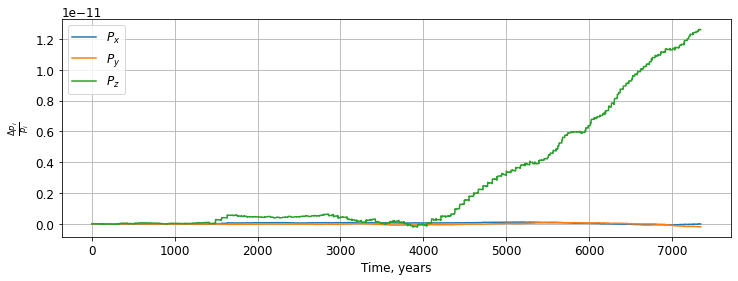

In [12]:
# Plotting the energy evolution
#plt.figure(figsize=(8,8))
#plt.title("Energy")
#plt.plot(t[1:],percentChangeE[1:])
#plt.xlabel("Time, years")
#plt.ylabel(" $\\frac{\Delta E}{E}$")

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,4))
#plt.subplots(2,1, sharex='all')
#plt.title("Momentum X")
#plt.subplot(3,1,1)
plt.plot(t[1:],percentChangePx[1:], label="$P_x$")
plt.xlabel("Time, years")
#plt.ylabel("$\\frac{\Delta p_x}{p_x}$")
plt.grid(True)

#plt.subplot(3,1,2)
plt.plot(t[1:],percentChangePy[1:], label="$P_y$")
#plt.plot(t[1:],percentChangePz[1:], label="$P_z$")
plt.xlabel("Time, years")
#plt.ylabel("$\\frac{\Delta p_y}{p_y}$")
plt.grid(True)

#plt.subplot(3,1,3)
plt.plot(t[1:],percentChangePz[1:], label="$P_z$")
#plt.plot(t[1:],percentChangePz[1:], label="$P_z$")
plt.xlabel("Time, years")
plt.ylabel("$\\frac{\Delta p_i}{p_i}$")
plt.grid(True)
plt.legend(loc="best")
plt.savefig("tenStarClusterP.png", dpi=300)


'''
plt.figure(figsize=(8,8))
plt.plot(x[1][1:], y[1][1:])
plt.xlabel("x, m")
plt.ylabel("y, m")

plt.figure(figsize=(8,8))
#plt.title("Timestep")
plt.plot(t,dts[1:])

plt.figure(figsize=(8,8))
#plt.title("Centre of Mass Distance")
for i in range(bodyAmount):
    plt.plot(t,dc[i][1:], label=i)
plt.xlabel("Time, years")
plt.ylabel("Distance from Centre of Mass, m")
#plt.legend(loc="best")

fig = plt.figure(figsize=(8,8))
#plt.title("Position")
ax = plt.axes(projection="3d")
for i in range(bodyAmount):
    plt.plot(x[i][1], y[i][1], z[i][1], "kx" )
    plt.plot(x[i][1:], y[i][1:], z[i][1:], label=i)
plt.xlabel("x, m")
plt.ylabel("y, m")
ax.set_zlabel("z, m")
#plt.legend(loc="best")

plt.show()'''


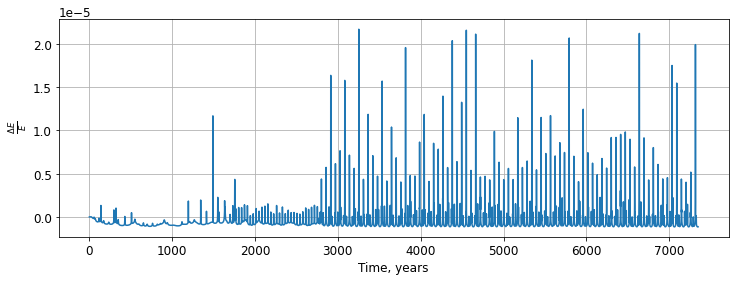

In [10]:
# Plotting the energy evolution
plt.figure(figsize=(12,4))

plt.rcParams.update({'font.size': 12})
#plt.title("Energy")
plt.plot(t[1:],percentChangeE[1:])
plt.xlabel("Time, years")
plt.ylabel(" $\\frac{\Delta E}{E}$")
plt.grid(True)
plt.savefig("tenStarClusterE.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t[1:], percentChangePx[1:], label="$P_x$", color="blue")
ax.set_xlabel("Time, years")
ax.set_ylabel("$\\frac{\Delta P_x}{P_x}$")
plt.grid(True)
ax2 = ax.twinx()
ax2.plot(t[1:], percentChangePy[1:], label="$P_y$", color="green")
ax2.plot((0,0), color="blue", label="$P_x$")
ax2.set_ylabel("$\\frac{\Delta P_y}{P_y}$")
plt.legend(loc="best")
plt.savefig("EarthSunP", dpi="figure")


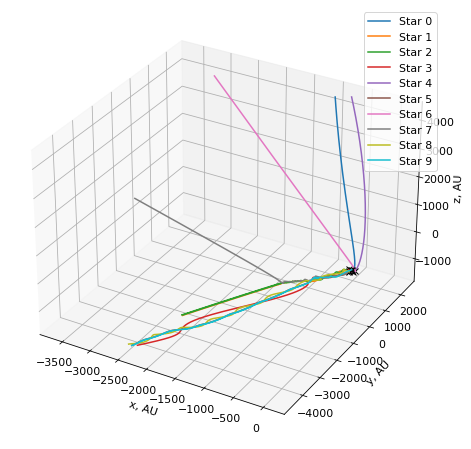

In [9]:
#%matplotlib widget
fig = plt.figure(figsize=(8,8))
#plt.title("Position")
ax = plt.axes(projection="3d")
for i in range(bodyAmount):
    plt.plot(x[i][1]/1.5e11, y[i][1]/1.5e11, z[i][1]/1.5e11, "kx" )
    plt.plot(x[i][1:]/1.5e11, y[i][1:]/1.5e11, z[i][1:]/1.5e11, label="Star %s" % (i))
plt.xlabel("x, AU")
plt.ylabel("y, AU")
ax.set_zlabel("z, AU")
plt.legend(loc="best")
plt.savefig("tenStarCluster.png", dpi=300)

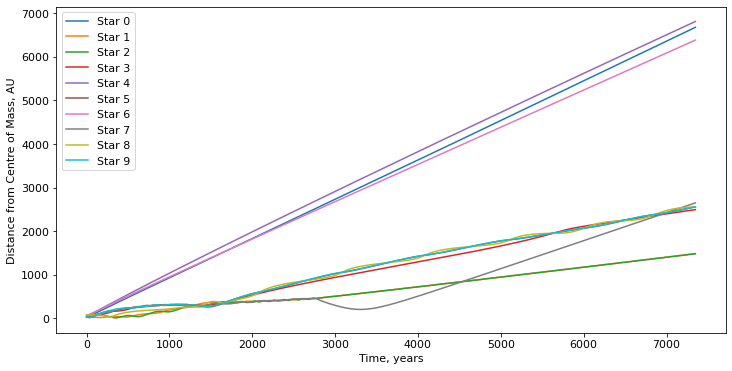

In [5]:
plt.figure(figsize=(12,6))
#plt.title("Centre of Mass Distance")
for i in range(bodyAmount):
    plt.plot(t,dc[i][1:]/1.5e11, label="Star %s" % (i))
plt.xlabel("Time, years")
plt.ylabel("Distance from Centre of Mass, AU")
#plt.xscale("log")
plt.legend(loc="best")
plt.savefig("tenStarClusterDCOM.png", dpi=300)